In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%qtconsole --colors=linux
plt.style.use('ggplot')

from matplotlib import gridspec
from theano import tensor as tt
from scipy import stats

# Chapter 11 - Signal detection theory
  
The basic data for an SDT analysis are  the counts of hits, false alarms, misses, and correct rejections. It is common to consider just the hit and false alarm counts which, together with the total number of signal and noise trials, completely describe the data.

|                  |   Signal trial   |   Noise trial    |
|:----------------:|:----------------:|:----------------:|
| Yes response     |        Hit       |   False alarm    |
| No response      |       Miss       |Correct rejection | 

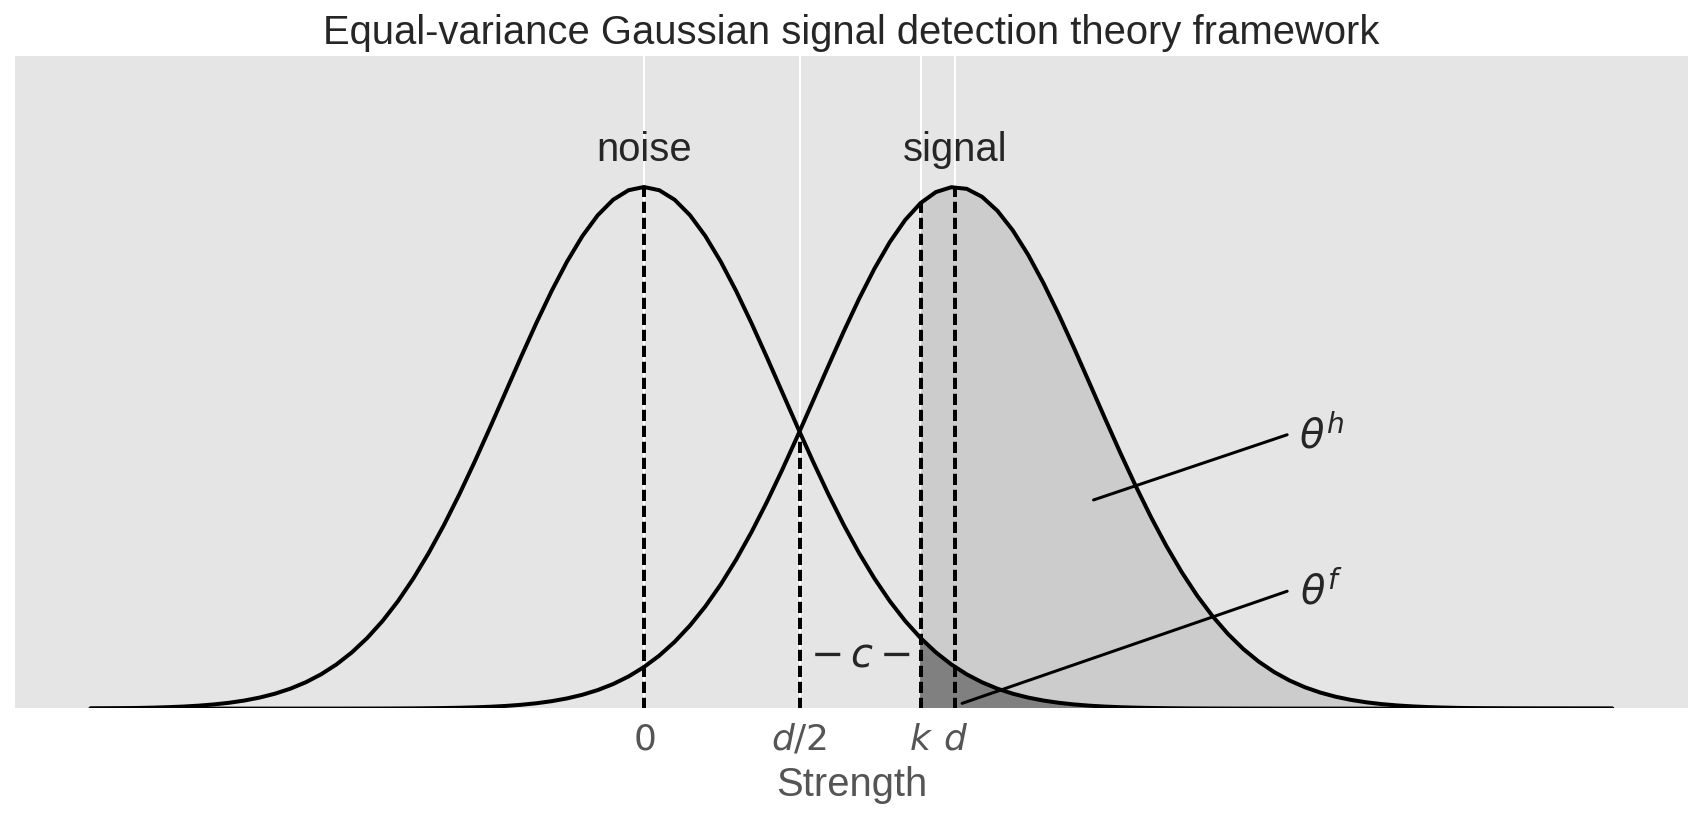

In [2]:
from matplotlib.patches import Polygon

func = stats.norm.pdf

a, b, d = 2, 7, 2.25  # integral limits 1
x = np.linspace(-4, b, 100)
y = func(x)
y2 = func(x, loc=d)

fig, ax = plt.subplots(figsize=(15, 6))

plt.plot(x, y, 'k', linewidth=2)
plt.plot(x, y2, 'k', linewidth=2)
d2 = x[y==y2]

# Make the shaded region
ix = np.linspace(a, b)
iy = func(ix)
iy2 = func(ix, loc=d)

verts = [(a, 0)] + list(zip(ix, iy2)) + [(b, 0)]
poly = Polygon(verts, facecolor='.8', edgecolor='1')
ax.add_patch(poly)

verts = [(a, 0)] + list(zip(ix, iy)) + [(b, 0)]
poly = Polygon(verts, facecolor='.5', edgecolor='0.5')
ax.add_patch(poly)

plt.text(0, y.max()+.02, "noise",
         horizontalalignment='center', fontsize=20)
plt.text(d, y.max()+.02, "signal",
         horizontalalignment='center', fontsize=20)
plt.text((d/2+a)/2, y.max()*.08, r"$ - \,c - $",
         horizontalalignment='center', fontsize=20)
plt.text(b*.7, y.max()*.5, r"$\theta^h$",
         horizontalalignment='center', fontsize=20)
plt.text(b*.7, y.max()*.2, r"$\theta^f$",
         horizontalalignment='center', fontsize=20)
plt.plot([d+1, b*.7-.25], [y.max()*.4, y.max()*.5+.01], color='k', linestyle='-', linewidth=1.5)
plt.plot([d+.05, b*.7-.25], [y.max()*.01, y.max()*.2+.01], color='k', linestyle='-', linewidth=1.5)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')

plt.plot([0, 0], [0, func(0)], color='k', linestyle='--', linewidth=2)
plt.plot([d/2, d/2], [0, func(d/2)], color='k', linestyle='--', linewidth=2)
plt.plot([a, a], [0, func(a, loc=d)], color='k', linestyle='--', linewidth=2)
plt.plot([d, d], [0, func(d, loc=d)], color='k', linestyle='--', linewidth=2)

ax.set_xticks((0, a, d, d/2))
ax.set_xticklabels(('$0$', '$k$', '$d$', '$d/2$'), fontsize=18)
ax.set_yticks([])
plt.ylim(0, y.max()+.1)
plt.title('Equal-variance Gaussian signal detection theory framework', fontsize=20)
plt.xlabel('Strength', fontsize=20)
plt.show()

## 11.1 Signal detection theory


$$ d_{i} \sim \text{Gaussian}(0,\frac{1}{2})$$
$$ c_{i} \sim \text{Gaussian}(0,2)$$
$$ \theta_{i}^h = \Phi(\frac{1}{2}d_{i}-c_{i})$$
$$ \theta_{i}^f = \Phi(-\frac{1}{2}d_{i}-c_{i})$$
$$ h_{i} \sim \text{Binomial}(\theta_{i}^h,s_{i})$$
$$ f_{i} \sim \text{Binomial}(\theta_{i}^f,n_{i})$$

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -18.92: 100%|██████████| 200000/200000 [00:09<00:00, 20966.66it/s] 
Finished [100%]: Average ELBO = -18.912
100%|██████████| 10000/10000.0 [00:09<00:00, 1067.86it/s]


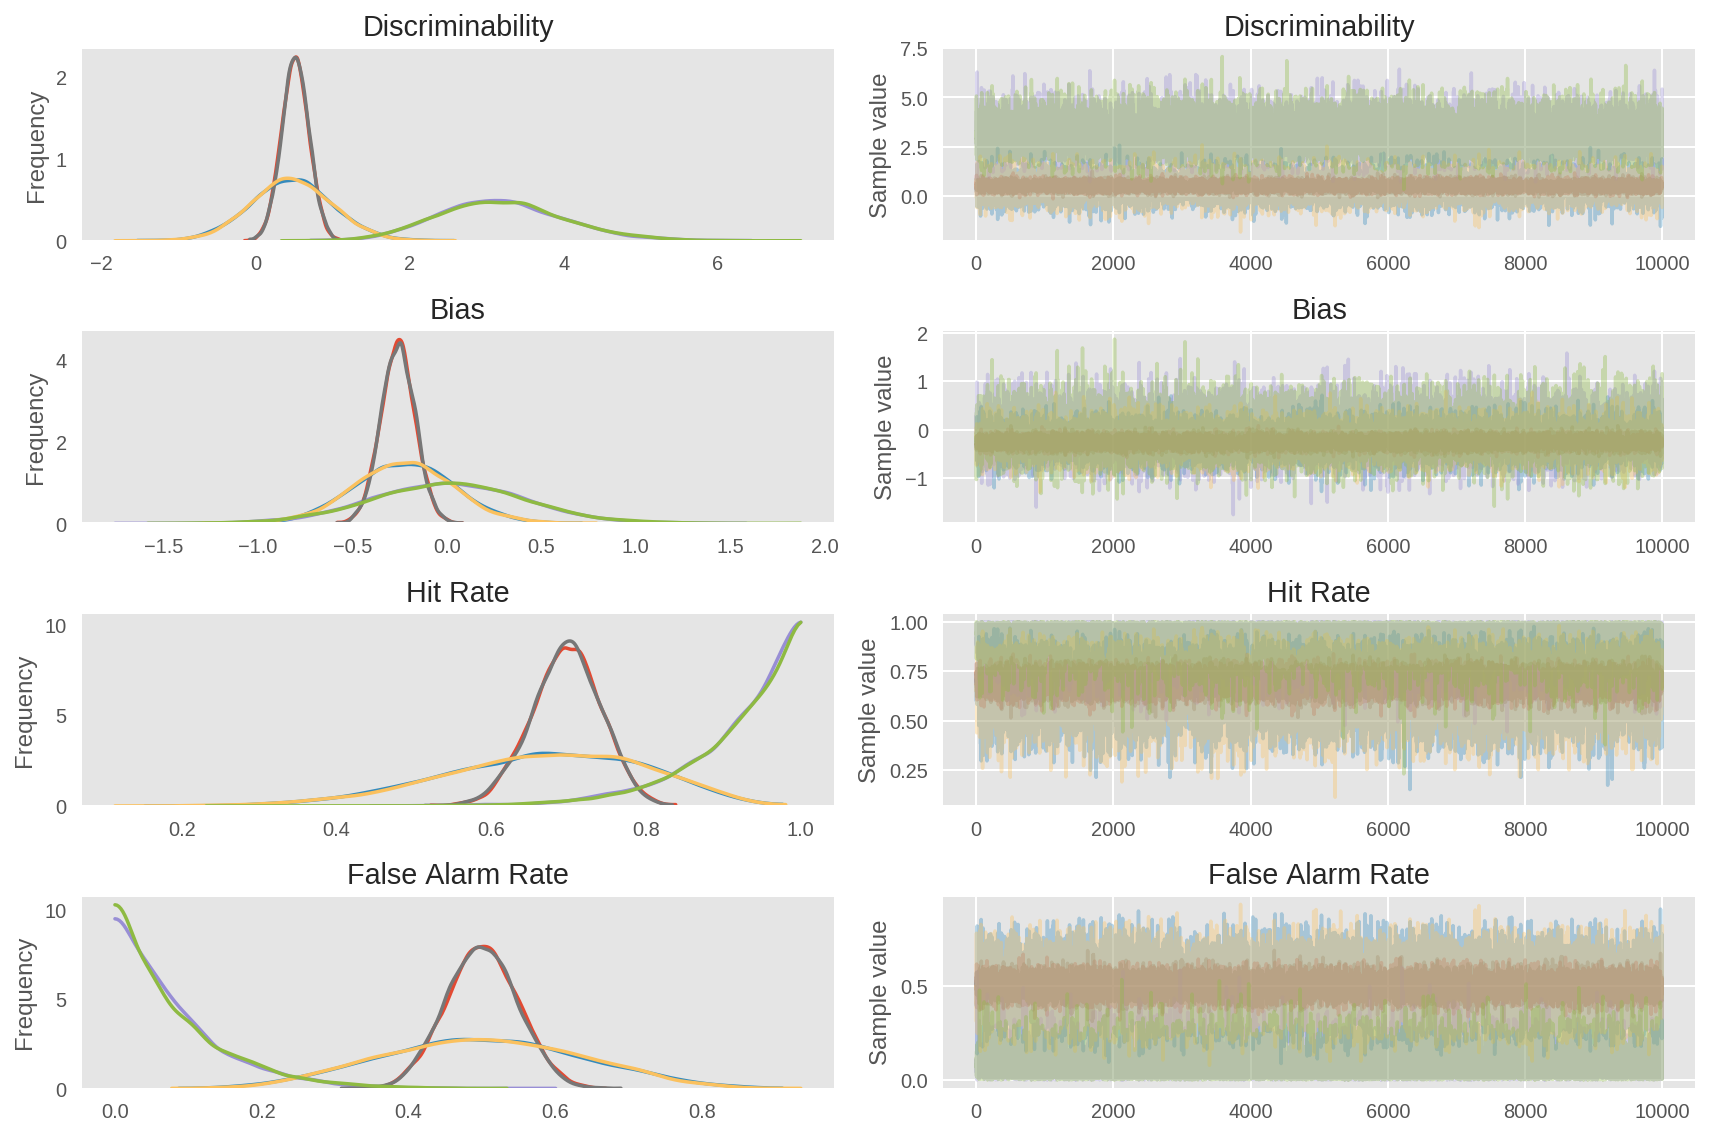

In [3]:
# Load data
dataset = 1
if dataset==1:  # Demo
    k = 3 # number of cases
    data =np.array([70, 50, 30, 50,
                    7,  5,  3,  5, 
                    10,  0,  0, 10]).reshape(k, -1)
else:  # Lehrner et al. (1995) data 
    k = 3 # number of cases
    data =np.array([148, 29, 32, 151,
                    150, 40, 30, 140,
                    150, 51, 40, 139]).reshape(k, -1)
    
h  = data[:, 0]
f  = data[:, 1]
MI = data[:, 2]
CR = data[:, 3]
s = h + MI
n = f + CR

def Phi(x):
        #'Cumulative distribution function for the standard normal distribution'
        # Also it is the probit transform 
        return (1.0 + tt.erf(x / tt.sqrt(2.0))) / 2.0
    
with pm.Model() as model1:
    di = pm.Normal('Discriminability', mu=0, tau=.5, shape= k)
    ci = pm.Normal('Bias', mu=0, tau=2, shape= k)
    
    thetah = pm.Deterministic('Hit Rate', Phi(di/2-ci))
    thetaf = pm.Deterministic('False Alarm Rate', Phi(-di/2-ci))
    
    hi = pm.Binomial('hi',p=thetah,n=s,observed=h)
    fi = pm.Binomial('fi',p=thetaf,n=n,observed=f)
    trace1=pm.sample(1e4, njobs=2)

burnin=0    
pm.traceplot(trace1[burnin:], 
             varnames=['Discriminability', 'Bias', 'Hit Rate', 'False Alarm Rate']);
plt.show()

## 11.2 Hierarchical signal detection theory
  
$$ \mu_{d},\mu_{c} \sim \text{Gaussian}(0,.001)$$
$$ \lambda_{d},\lambda_{c} \sim \text{Gamma}(.001,.001)$$
$$ d_{i} \sim \text{Gaussian}(\mu_{d},\lambda_{d})$$
$$ c_{i} \sim \text{Gaussian}(\mu_{c},\lambda_{c})$$
$$ \theta_{i}^h = \Phi(\frac{1}{2}d_{i}-c_{i})$$
$$ \theta_{i}^f = \Phi(-\frac{1}{2}d_{i}-c_{i})$$
$$ h_{i} \sim \text{Binomial}(\theta_{i}^h,s_{i})$$
$$ f_{i} \sim \text{Binomial}(\theta_{i}^f,n_{i})$$

In [4]:
# Load data using rpy2
from rpy2 import *
%load_ext rpy2.ipython
%R source("data/heit_rotello.RData") -o std_i -o std_d 
# the induction data and the deduction data

h1  = np.array(std_i['V1'])
f1  = np.array(std_i['V2'])
MI1 = np.array(std_i['V3'])
CR1 = np.array(std_i['V4'])
s1 = h1 + MI1
n1 = f1 + CR1

h2  = np.array(std_d['V1'])
f2  = np.array(std_d['V2'])
MI2 = np.array(std_d['V3'])
CR2 = np.array(std_d['V4'])
s2 = h2 + MI2
n2 = f2 + CR2

k=len(h1)

In [6]:
with pm.Model() as model2i:
    mud = pm.Normal('mud', mu=0, tau=.001)
    muc = pm.Normal('muc', mu=0, tau=.001)
    lambdad = pm.Gamma('lambdad', alpha=.001, beta=.001)
    lambdac = pm.Gamma('lambdac', alpha=.001, beta=.001)
    
    di = pm.Normal('di', mu=mud, tau=lambdad, shape= k)
    ci = pm.Normal('ci', mu=muc, tau=lambdac, shape= k)

    thetah = pm.Deterministic('Hit Rate', Phi(di/2-ci))
    thetaf = pm.Deterministic('False Alarm Rate', Phi(-di/2-ci))

    hi = pm.Binomial('hi', p=thetah, n=s1, observed=h1)
    fi = pm.Binomial('fi', p=thetaf, n=n1, observed=f1)
    trace_i=pm.sample(3e3, njobs=2)
    
with pm.Model() as model2d:
    mud = pm.Normal('mud', mu=0, tau=.001)
    muc = pm.Normal('muc', mu=0, tau=.001)
    lambdad = pm.Gamma('lambdad', alpha=.001, beta=.001)
    lambdac = pm.Gamma('lambdac', alpha=.001, beta=.001)
    
    di = pm.Normal('di', mu=mud,tau=lambdad,shape= k)
    ci = pm.Normal('ci', mu=muc,tau=lambdac, shape= k)
    
    thetah = pm.Deterministic('Hit Rate', Phi(di/2-ci))
    thetaf = pm.Deterministic('False Alarm Rate', Phi(-di/2-ci))

    hi = pm.Binomial('hi', p=thetah, n=s2, observed=h2)
    fi = pm.Binomial('fi', p=thetaf, n=n2, observed=f2)
    trace_d=pm.sample(3e3, njobs=2)
    

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -121.39: 100%|██████████| 200000/200000 [00:19<00:00, 10092.87it/s]
Finished [100%]: Average ELBO = -121.4
100%|██████████| 3000/3000.0 [00:09<00:00, 312.25it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -113.51: 100%|██████████| 200000/200000 [00:20<00:00, 9668.32it/s]
Finished [100%]: Average ELBO = -113.54
100%|██████████| 3000/3000.0 [00:09<00:00, 329.40it/s]


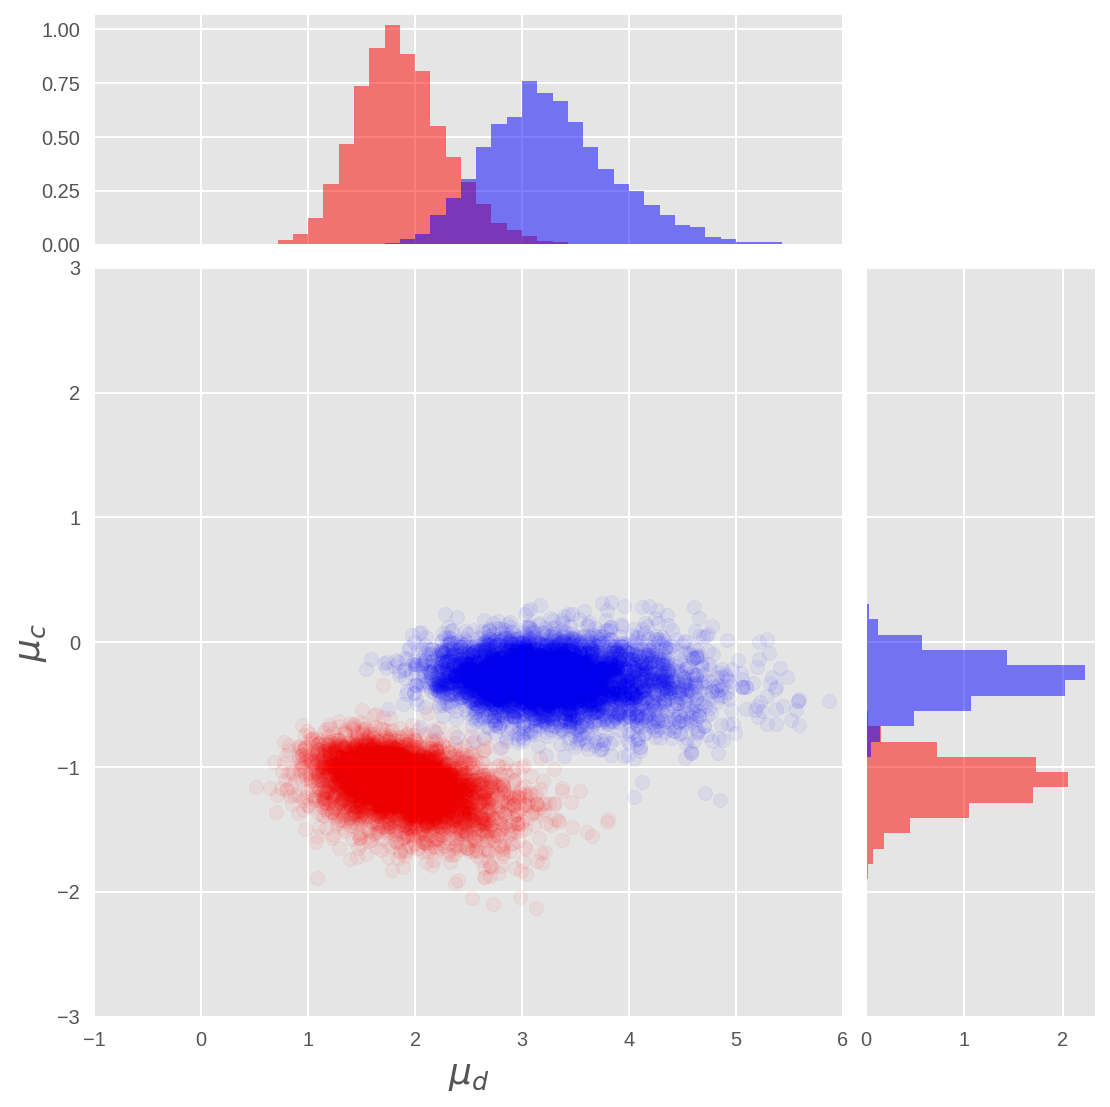

In [22]:
def scatterplot_2trace(trace1, trace2):
    from matplotlib.ticker import NullFormatter
    nullfmt = NullFormatter()         # no labels

    burnin=500 # set to zero to plot the one without burnin

    # definitions for the axes
    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    bottom_h = left_h = left + width + 0.02

    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom_h, width, 0.2]
    rect_histy = [left_h, bottom, 0.2, height]

    # now determine limits by hand:
    binwidth1 = 0.25

    # start with a rectangular Figure
    plt.figure(1, figsize=(8, 8))

    cc = np.array([[1,0,0],[0,0,1]])

    for idd in np.arange(2):
        if idd==0:
            x = trace1['mud'][burnin:]
            y = trace1['muc'][burnin:]
        else:
            x = trace2['mud'][burnin:]
            y = trace2['muc'][burnin:]

        axScatter = plt.axes(rect_scatter)
        axScatter.set_xlim((-1, 6))
        axScatter.set_ylim((-3, 3))

        axHistx = plt.axes(rect_histx)
        axHisty = plt.axes(rect_histy)

        # no labels
        axHistx.xaxis.set_major_formatter(nullfmt)
        axHisty.yaxis.set_major_formatter(nullfmt)

        # the scatter plot:
        axScatter.scatter(x, y,c=cc[idd,:],alpha=.05)
        axScatter.set_xlabel(r'$\mu_d$',fontsize=18)
        axScatter.set_ylabel(r'$\mu_c$',fontsize=18)

        bins1 = np.linspace(-1, 6, 50)
        axHistx.hist(x, bins=bins1,color=cc[idd,:],alpha=.5,normed=True)
        bins2 = np.linspace(-3, 3, 50)
        axHisty.hist(y, bins=bins2, color=cc[idd,:],alpha=.5,normed=True, orientation='horizontal')

        axHistx.set_xlim(axScatter.get_xlim())
        axHisty.set_ylim(axScatter.get_ylim())

    plt.show()

scatterplot_2trace(trace_i, trace_d)

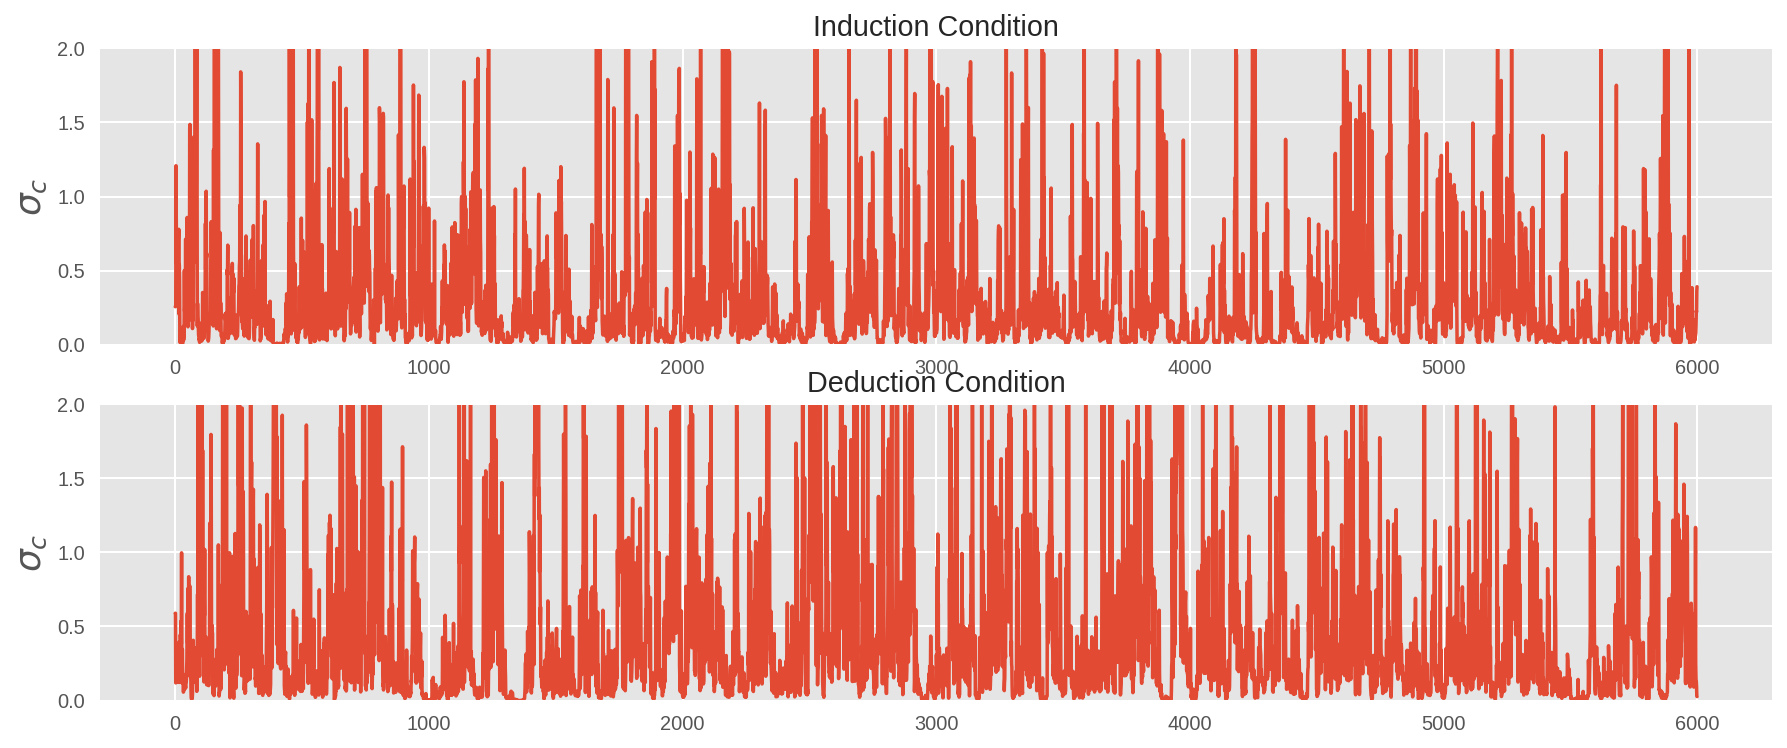

In [8]:
tmptrace = trace_i['lambdac'][:]
plt.figure(figsize=(15, 6))
gs = gridspec.GridSpec(2,1)
plt.subplot(gs[0])
plt.plot(1/tmptrace**2)
plt.ylim(0,2)
plt.title('Induction Condition')
plt.ylabel(r'$\sigma_c$',fontsize=18)
plt.subplot(gs[1])
tmptrace = trace_d['lambdac'][:]
plt.plot(1/tmptrace**2)
plt.ylim(0,2)
plt.title('Deduction Condition')
plt.ylabel(r'$\sigma_c$',fontsize=18)
plt.show()

## 11.3 Parameter expansion
  
  
Using parameter expansion to escape the "zero variance trap" in MCMC sampling.  

$$ \mu_{d},\mu_{c} \sim \text{Gaussian}(0,.001)$$
$$ \lambda_{d},\lambda_{c} \sim \text{Gamma}(.001,.001)$$
$$ \xi_{d},\xi_{c} \sim \text{Beta}(1,1)$$
$$ \delta_{d_{i}} \sim \text{Gaussian}(0,\lambda_{d})$$
$$ \delta_{c_{i}} \sim \text{Gaussian}(0,\lambda_{c})$$
$$ \sigma_{d} = \lvert \xi_{d}\rvert\,/\,\sqrt\lambda_{d}$$
$$ \sigma_{c} = \lvert \xi_{c}\rvert\,/\,\sqrt\lambda_{c}$$
$$ d_{i} = \mu_{d} + \xi_{d}\delta_{d_{i}}$$
$$ c_{i} = \mu_{c} + \xi_{c}\delta_{c_{i}}$$
$$ \theta_{i}^h = \Phi(\frac{1}{2}d_{i}-c_{i})$$
$$ \theta_{i}^f = \Phi(-\frac{1}{2}d_{i}-c_{i})$$
$$ h_{i} \sim \text{Binomial}(\theta_{i}^h,s_{i})$$
$$ f_{i} \sim \text{Binomial}(\theta_{i}^f,n_{i})$$

In [9]:
with pm.Model() as model3i:
    mud = pm.Normal('mud', mu=0, tau=.001)
    muc = pm.Normal('muc', mu=0, tau=.001)
    lambdad = pm.Gamma('lambdad', alpha=.001, beta=.001)
    lambdac = pm.Gamma('lambdac', alpha=.001, beta=.001)
    xid = pm.Uniform('xid', lower=0, upper=1)
    xic = pm.Uniform('xic', lower=0, upper=1)
    deltadi = pm.Normal('deltadi', mu=0, tau=lambdad, shape=k)
    deltaci = pm.Normal('deltaci', mu=0, tau=lambdac, shape=k)
    
    sigmad = pm.Deterministic('sigmad', xid/tt.sqrt(lambdad))
    sigmac = pm.Deterministic('sigmac', xic/tt.sqrt(lambdac))
    
    di = pm.Deterministic('di', mud+xid*deltadi)
    ci = pm.Deterministic('ci', muc+xic*deltaci)
    
    thetah = pm.Deterministic('Hit Rate', Phi(di/2-ci))
    thetaf = pm.Deterministic('False Alarm Rate', Phi(-di/2-ci))

    hi = pm.Binomial('hi', p=thetah, n=s1, observed=h1)
    fi = pm.Binomial('fi', p=thetaf, n=n1, observed=f1)
    trace_i2=pm.sample(3e3, njobs=2)
    
with pm.Model() as model3d:
    mud = pm.Normal('mud', mu=0, tau=.001)
    muc = pm.Normal('muc', mu=0, tau=.001)
    lambdad = pm.Gamma('lambdad', alpha=.001, beta=.001)
    lambdac = pm.Gamma('lambdac', alpha=.001, beta=.001)
    xid = pm.Uniform('xid', lower=0, upper=1)
    xic = pm.Uniform('xic', lower=0, upper=1)
    deltadi = pm.Normal('deltadi', mu=0, tau=lambdad, shape=k)
    deltaci = pm.Normal('deltaci', mu=0, tau=lambdac, shape=k)
    
    sigmad = pm.Deterministic('sigmad', xid/tt.sqrt(lambdad))
    sigmac = pm.Deterministic('sigmac', xic/tt.sqrt(lambdac))
    
    di = pm.Deterministic('di', mud+xid*deltadi)
    ci = pm.Deterministic('ci', muc+xic*deltaci)
    
    thetah = pm.Deterministic('Hit Rate', Phi(di/2-ci))
    thetaf = pm.Deterministic('False Alarm Rate', Phi(-di/2-ci))

    hi = pm.Binomial('hi', p=thetah, n=s2, observed=h2)
    fi = pm.Binomial('fi', p=thetaf, n=n2, observed=f2)
    trace_d2=pm.sample(3e3, njobs=2)
    

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -127.36: 100%|██████████| 200000/200000 [00:23<00:00, 8645.59it/s]
Finished [100%]: Average ELBO = -128
100%|██████████| 3000/3000.0 [01:34<00:00, 31.84it/s] 
Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -119.14: 100%|██████████| 200000/200000 [00:23<00:00, 8465.59it/s]
Finished [100%]: Average ELBO = -119.7
100%|██████████| 3000/3000.0 [00:58<00:00, 51.65it/s] 


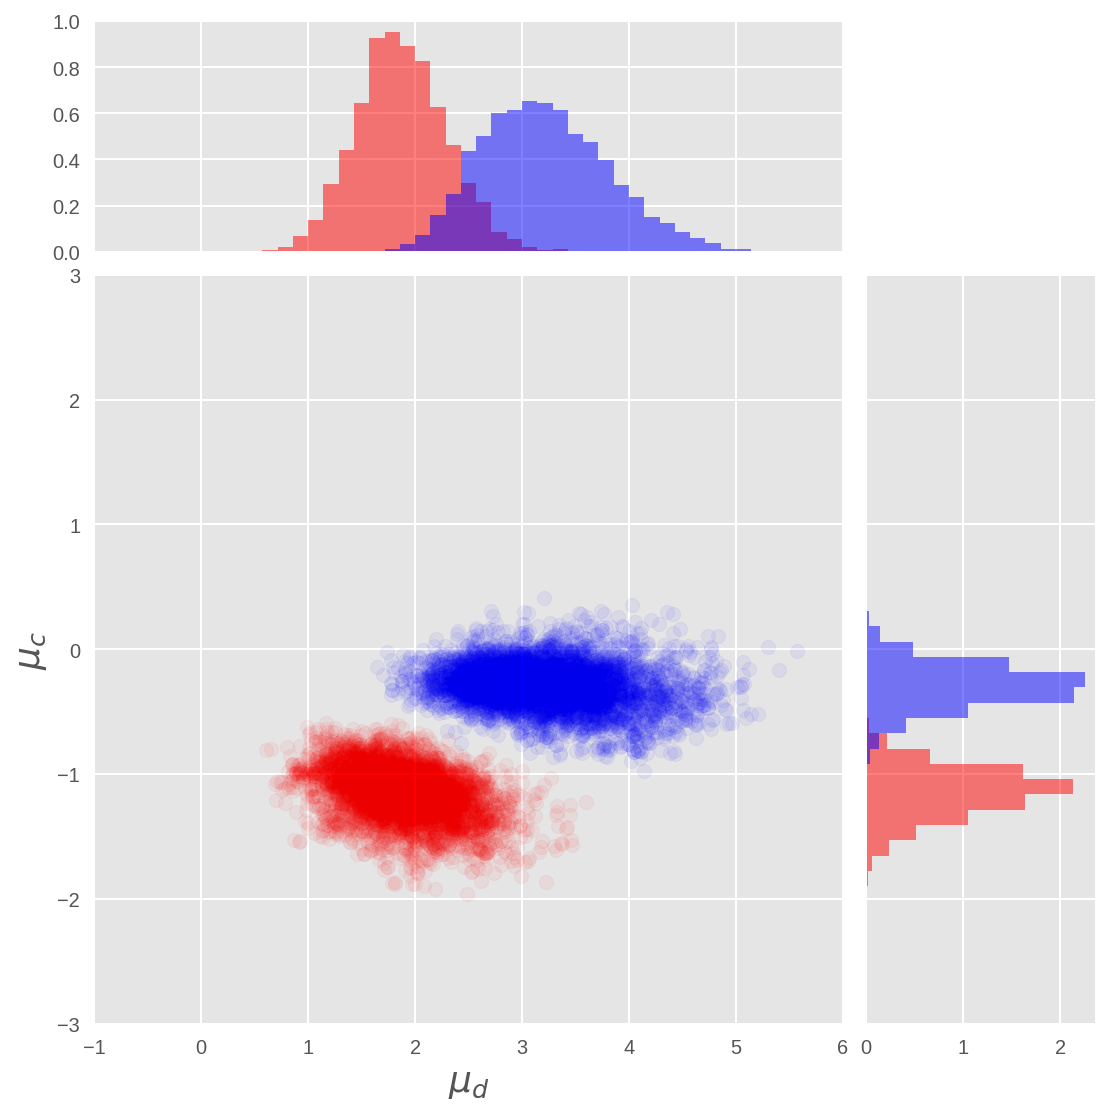

In [23]:
scatterplot_2trace(trace_i2, trace_d2)

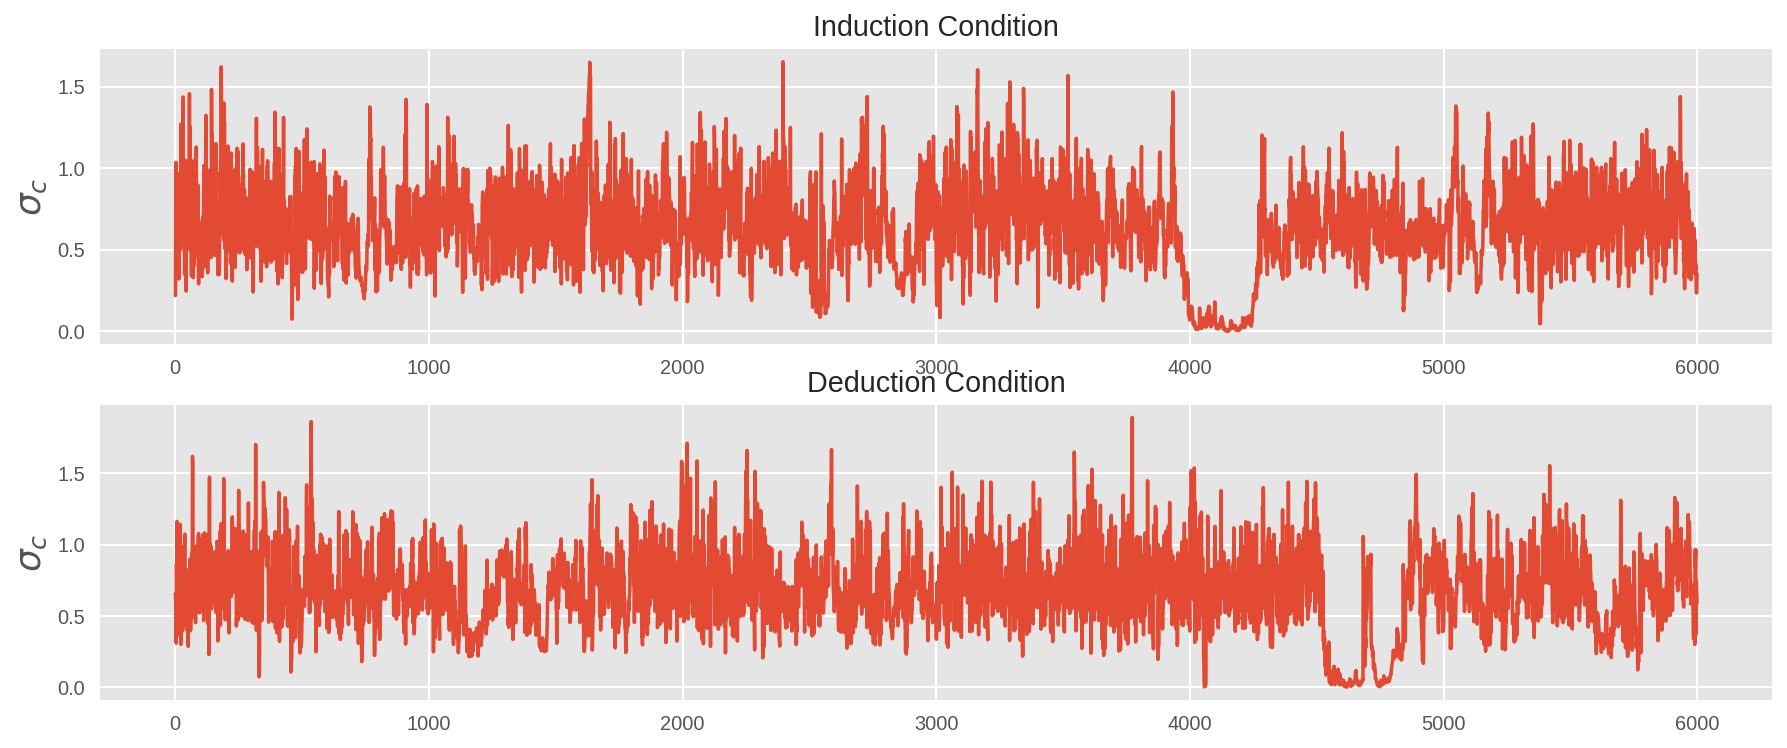

In [12]:
tmptrace = trace_i2['sigmac'][:]
plt.figure(figsize=(15, 6))
gs = gridspec.GridSpec(2,1)
plt.subplot(gs[0])
plt.plot(tmptrace)

plt.title('Induction Condition')
plt.ylabel(r'$\sigma_c$',fontsize=18)
plt.subplot(gs[1])
tmptrace = trace_d2['sigmac'][:]
plt.plot(tmptrace)

plt.title('Deduction Condition')
plt.ylabel(r'$\sigma_c$',fontsize=18)
plt.show()

# Additional:
Sampling using HMC (e.g., in STAN and PyMC3), there are better way to diagnose biased inference [[1]](http://mc-stan.org/documentation/case-studies/divergences_and_bias.html), [[2]](http://pymc-devs.github.io/pymc3/notebooks/Diagnosing_biased_Inference_with_Divergences.html).

In [13]:
def plot_samplerstat(burnin, trace):
    # Sampler statistics
    accept = trace.get_sampler_stats('mean_tree_accept', burn=burnin)
    print('The accept rate is: %.5f' % (accept.mean()))
    diverge = trace.get_sampler_stats('diverging')
    print('Diverge of the trace')
    print(diverge.nonzero())
    energy = trace['energy']
    energy_diff = np.diff(energy)
    sns.distplot(energy - energy.mean(), label='energy')
    sns.distplot(energy_diff, label='energy diff')
    plt.legend()
    plt.show()

The accept rate is: 0.79996
Diverge of the trace
(array([   1,   79,  173,  351,  453,  570,  658,  734,  752,  887,  891,
        982,  983, 1063, 1134, 1139, 1146, 1661, 1669, 1670, 1703, 1762,
       1781, 1785, 1787, 1983, 2155, 2158, 2172, 2176, 2177, 2674, 2745,
       2763, 2886, 2887, 2977, 2992, 3017, 3135, 3138, 3159, 3199, 3579,
       3897, 4613, 4791, 4878, 4881, 5034, 5201, 5268, 5274, 5574, 5879,
       5880, 5881]),)


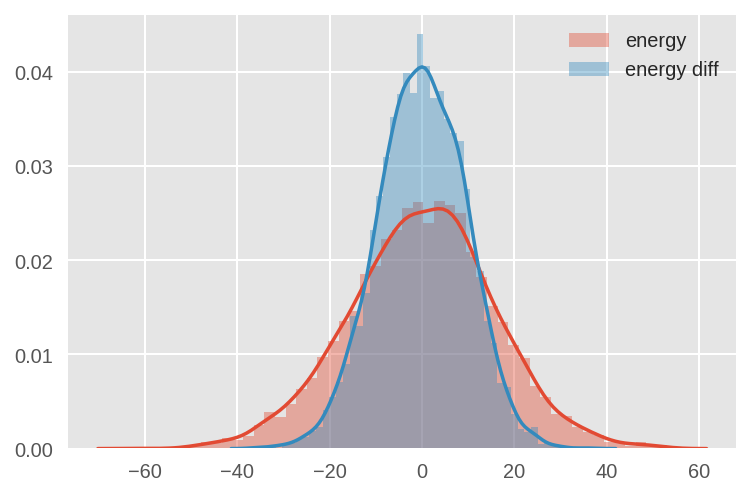

In [18]:
plot_samplerstat(2000, trace_i)

The accept rate is: 0.79929
Diverge of the trace
(array([   1,    8,   52,   89,  117,  147,  191,  252,  254,  257,  271,
        272,  299,  509,  613,  639,  640,  641,  642,  644,  648,  768,
        794,  798,  799,  813,  817,  884,  939, 1269, 1270, 1271, 1272,
       1288, 1415, 1416, 1417, 1420, 1421, 1422, 1423, 1424, 1427, 1428,
       1429, 1432, 1440, 1556, 1648, 1751, 1754, 1756, 1757, 1758, 1781,
       1801, 1864, 1873, 1894, 1937, 1938, 1979, 2028, 2041, 2060, 2061,
       2324, 2325, 2326, 2327, 2504, 2509, 2513, 2514, 2515, 2517, 2520,
       2521, 2522, 2524, 2569, 2621, 2629, 2665, 2666, 2670, 2675, 2679,
       2768, 2804, 2805, 2824, 2847, 2851, 2859, 2861, 2878, 2895, 2905,
       3001, 3068, 3179, 3216, 3234, 3256, 3258, 3344, 3349, 3357, 3441,
       3465, 3514, 3519, 3520, 3522, 3586, 3656, 3713, 3716, 3726, 3761,
       3791, 3793, 3815, 3841, 3843, 3844, 3845, 3846, 3931, 3947, 3948,
       3949, 3950, 3951, 3952, 3953, 3954, 3955, 3956, 3957, 3958, 3959,
 

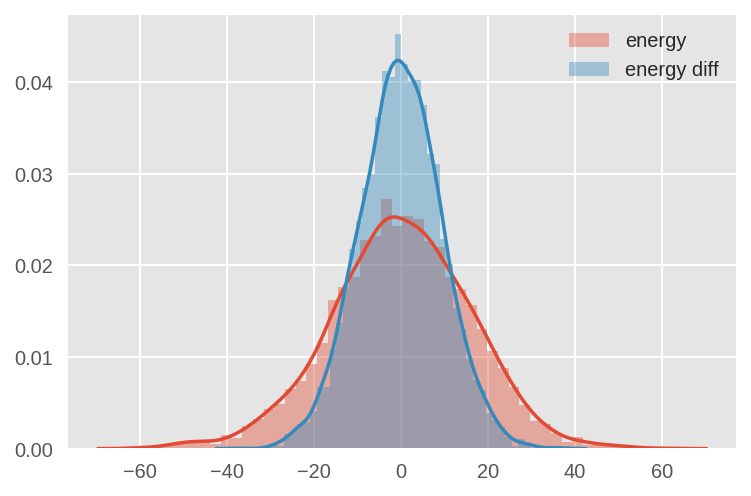

In [19]:
plot_samplerstat(2000, trace_d)

The accept rate is: 0.79946
Diverge of the trace
(array([  20,   41,   48,   58,   62,  145,  147,  152,  153,  160,  166,
        168,  169,  176,  177,  180,  181,  182,  184,  185,  186,  210,
        223,  235,  272,  283,  287,  300,  304,  317,  476,  556,  587,
        588,  592,  594,  953,  972, 1016, 1032, 1070, 1222, 1241, 1247,
       1251, 1252, 1271, 1278, 1279, 1281, 1282, 1293, 1326, 1331, 1332,
       1360, 1506, 1534, 1538, 1540, 1541, 1556, 1557, 1565, 1569, 1579,
       1586, 1591, 1618, 1619, 1623, 1624, 1625, 1626, 1627, 1628, 1629,
       1630, 1631, 1632, 1633, 1634, 1635, 1636, 1637, 1638, 1662, 1715,
       1744, 1750, 1758, 1760, 1766, 1799, 1800, 1851, 2011, 2069, 2070,
       2073, 2075, 2085, 2144, 2145, 2168, 2169, 2199, 2213, 2286, 2319,
       2324, 2373, 2384, 2414, 2416, 2422, 2607, 2790, 2931, 2932, 2968,
       2971, 2972, 2982, 2983, 2993, 3037, 3043, 3144, 3145, 3148, 3149,
       3152, 3159, 3250, 3289, 3312, 3356, 3396, 3406, 3574, 3606, 3620,
 

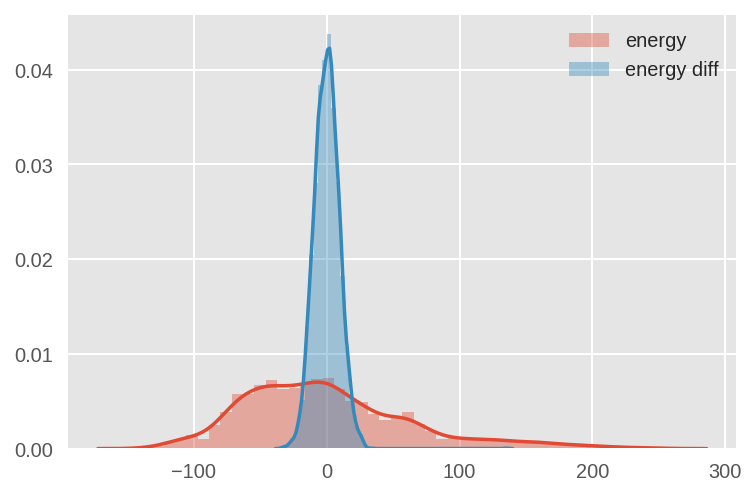

In [20]:
plot_samplerstat(2000, trace_i2)

The accept rate is: 0.79757
Diverge of the trace
(array([   8,   13,   15,   24,   35,   70,   91,   92,  132,  133,  140,
        154,  192,  193,  207,  215,  226,  227,  230,  231,  233,  235,
        236,  259,  266,  267,  278,  293,  296,  325,  326,  349,  350,
        351,  352,  353,  354,  355,  356,  357,  358,  359,  360,  361,
        362,  363,  364,  365,  385,  388,  420,  451,  519,  543,  544,
        561,  562,  588,  590,  606,  674,  676,  680,  683,  694,  696,
        697,  718,  755,  759,  836,  838,  859,  878,  967,  991, 1022,
       1031, 1035, 1036, 1053, 1054, 1055, 1086, 1144, 1210, 1214, 1292,
       1297, 1301, 1302, 1303, 1304, 1305, 1306, 1309, 1354, 1482, 1657,
       1658, 1664, 1665, 1671, 1672, 1673, 1741, 1747, 1769, 1796, 1797,
       1799, 1879, 1880, 1881, 1882, 1883, 1884, 1885, 1886, 1887, 1892,
       1894, 1895, 1896, 1901, 1902, 1903, 1904, 1907, 1912, 1915, 1921,
       1927, 1933, 1952, 1957, 1965, 1969, 1976, 1977, 1978, 1981, 1987,
 

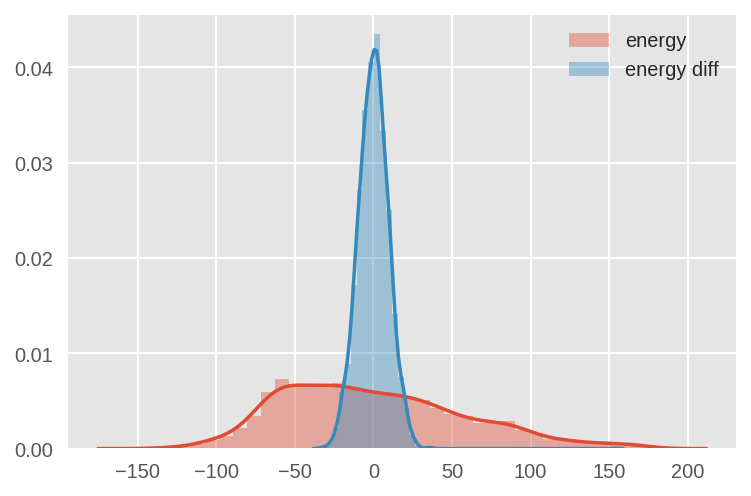

In [21]:
plot_samplerstat(2000, trace_d2)

As shown above, there are a lot of divergences in the trace, and the energy plot is very different from the energy_diff. This is a strong indication of bias in the estimation and better reparameterization is definitely needed.